# Protein LSTM: No Tokenization

In [6]:
# (Please, be aware that it might be necessary to import this library for the hiperparameter tuning)
!pip install bayesian-optimization

In [7]:
# Set Up & Libraries

import pandas as pd
import numpy as np
import time
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import KFold
from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, ConfusionMatrixDisplay, confusion_matrix
import os
import random
import seaborn as sns

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}')
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'

seed = 10
torch.manual_seed(seed)
np.random.seed(seed)

Device: cuda


In [8]:
# Importing Dataset
df = pd.read_csv("/content/2018-06-06-pdb-intersect-pisces.csv")
print(df.shape)
print(df.columns)

(9078, 11)
Index(['pdb_id', 'chain_code', 'seq', 'sst8', 'sst3', 'len', 'has_nonstd_aa',
       'Exptl.', 'resolution', 'R-factor', 'FreeRvalue'],
      dtype='object')


In [9]:
# Test Set

test_size = int(df.shape[0]*0.1) # 10% of data for test set
test_ix = random.sample([i for i in range(df.shape[0])] , test_size)
df_test = df.iloc[test_ix]
df = df.drop(test_ix)
print(df.shape)
print(df_test.shape)

(8171, 11)
(907, 11)


# Preprocessing

(Please, be aware that this section is the same across notebooks with the same tokenization technique)

## Padding & Cropping

In [10]:
def pad_sequence(seq_df, maxlen):
    """This function pads with dots a sequence until it has the desired length"""
    out = ['<'+i+'>'+'.'*(maxlen-len(i)) for i in seq_df]
    return out

def crop_sequence(seq_long , max_len):
    """This function breaks a sequence into subsequences of the desired length"""
    # Cracking Sequence
    out_1 = ['<'+seq_long[j][i-max_len:i]+'.' if i==0 else '.'+seq_long[j][i-max_len:i]+'.' for j in seq_long.index for i in range(max_len , len(seq_long[j]) , max_len)]
    # Extracting and padding last part of each sequence
    out_2 = [seq_long[j][max_len * (int(len(seq_long[j])/max_len)) : len(seq_long[j])] for j in seq_long.index]
    out_2 = pad_sequence(out_2 , max_len)
    # Unifying both
    out_1.extend(out_2)
    return out_1

def crop_pad_sequences(df , max_len):
  # Dividing Dataset
  df_short = df[df['seq'].str.len() < max_len] # Needs padding
  df_exact = df[df['seq'].str.len() == max_len] # Nothing
  df_long = df[df['seq'].str.len() > max_len] # Needs Cropping

  # Preparing features
  seq_short = pad_sequence(df_short['seq'], max_len)
  seq_exact = ['<'+i+'>' for i in df_exact['seq']]
  seq_long = crop_sequence(df_long['seq'], max_len)
  seq_features = [i for l in [seq_short, seq_exact, seq_long] for i in l] # Joining all three
  print(f'Number of Sequences: {len(seq_features)}')

  # Preparing q3
  q3_short = pad_sequence(df_short['sst3'], max_len)
  q3_exact = ['<'+i+'>' for i in df_exact['sst3']]
  q3_long = crop_sequence(df_long['sst3'], max_len)
  q3 = [i for l in [q3_short, q3_exact, q3_long] for i in l] # Joining all three
  print(f'Number of Sequences: {len(q3)}')

  # Preparing q8
  q8_short = pad_sequence(df_short['sst8'], max_len)
  q8_exact = ['<'+i+'>' for i in df_exact['sst8']]
  q8_long = crop_sequence(df_long['sst8'], max_len)
  q8 = [i for l in [q8_short, q8_exact, q8_long] for i in l] # Joining all three
  print(f'Number of Sequences: {len(q8)}')

  # Checking
  for i in [q8 , q3 , seq_features]:
      lens = [len(j) for j in i]
      print(f'Sequences without desired length: {[j for j in lens if j != max_len+2]}')

  return seq_features , q3 , q8


In [11]:
# Sequence Standarization
max_len = int(np.mean(df['len'])) #Hyperparam

seq_features , q3 , q8 = crop_pad_sequences(df , max_len)

Number of Sequences: 12283
Number of Sequences: 12283
Number of Sequences: 12283
Sequences without desired length: []
Sequences without desired length: []
Sequences without desired length: []


## Encoders, Decoders & Vocabs

In [12]:
def enc_dec_vocab(sequence):
  seq_vocab = np.unique([j for i in sequence for j in i]) # Vocab Dictionary
  seq_stoi = {str(j):i for i,j in enumerate(seq_vocab)} # String-to-Int
  seq_itos = {i:str(j) for i,j in enumerate(seq_vocab)} # Int-to-String
  seq_encoder = lambda s: [seq_stoi[c] for c in s] # encoder function
  seq_decoder = lambda s: [seq_itos[c] for c in s] # decoder function
  print(f'Sequence vocabulary: {seq_vocab} | Vocab Length: {len(seq_vocab)}\n\n')

  return seq_encoder , seq_decoder , seq_vocab, seq_stoi, seq_itos

In [13]:
# Features
seq_encoder , seq_decoder , seq_vocab, seq_stoi, seq_itos = enc_dec_vocab(seq_features)
# Q3
q3_encoder , q3_decoder , q3_vocab, q3_stoi, q3_itos = enc_dec_vocab(q3)
# Q8
q8_encoder , q8_decoder , q8_vocab, q8_stoi, q8_itos = enc_dec_vocab(q8)

Sequence vocabulary: ['*' '.' '<' '>' 'A' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'K' 'L' 'M' 'N' 'P' 'Q'
 'R' 'S' 'T' 'V' 'W' 'Y'] | Vocab Length: 24


Sequence vocabulary: ['.' '<' '>' 'C' 'E' 'H'] | Vocab Length: 6


Sequence vocabulary: ['.' '<' '>' 'B' 'C' 'E' 'G' 'H' 'I' 'S' 'T'] | Vocab Length: 11




## Data Exploration


Descriptive Statistics for Sequence Lengths:
count    8171.000000
mean      242.865378
std       155.451869
min        20.000000
25%       132.000000
50%       209.000000
75%       323.000000
max      1632.000000
Name: len, dtype: float64


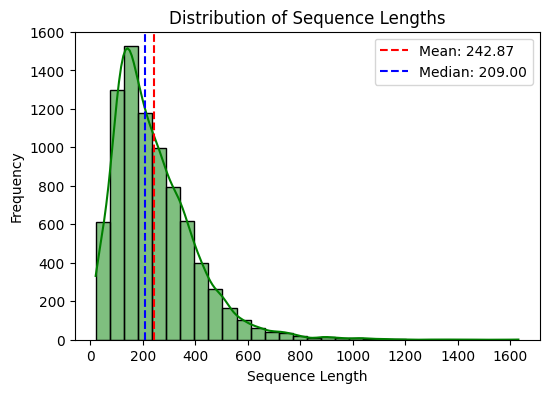

In [14]:
# Descriptive statistics for sequence lengths
sequence_lengths = df['len']
print("\nDescriptive Statistics for Sequence Lengths:")
print(sequence_lengths.describe())

# Visualizing the distribution with descriptive statistics
plt.figure(figsize=(6, 4))
sns.histplot(sequence_lengths, bins=30, kde=True, color='green')
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.axvline(sequence_lengths.mean(), color='r', linestyle='--', label=f'Mean: {sequence_lengths.mean():.2f}')
plt.axvline(sequence_lengths.median(), color='b', linestyle='--', label=f'Median: {sequence_lengths.median():.2f}')
plt.legend()
plt.show()


# Conclusion: Highly skewed distribution of lengths

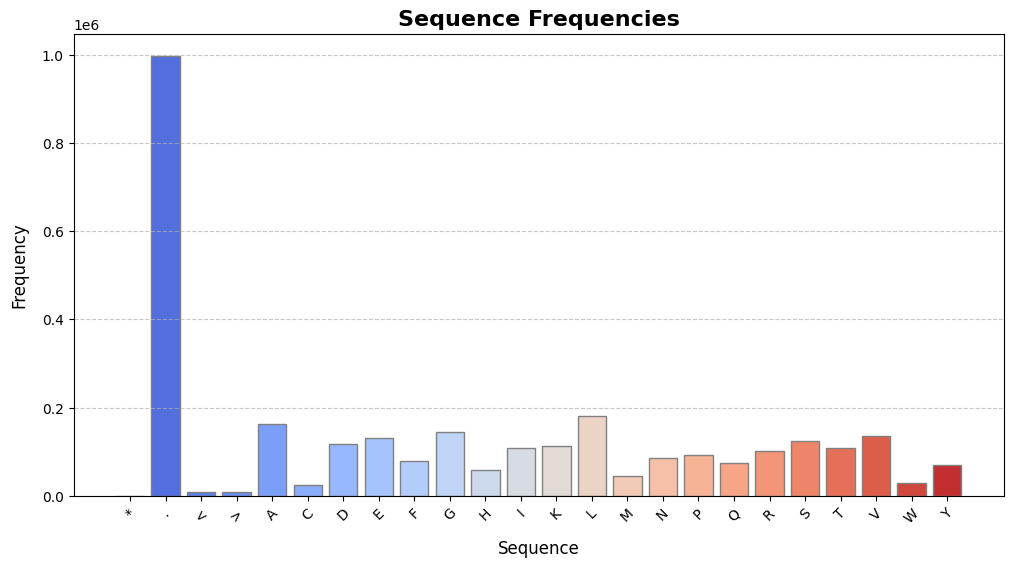

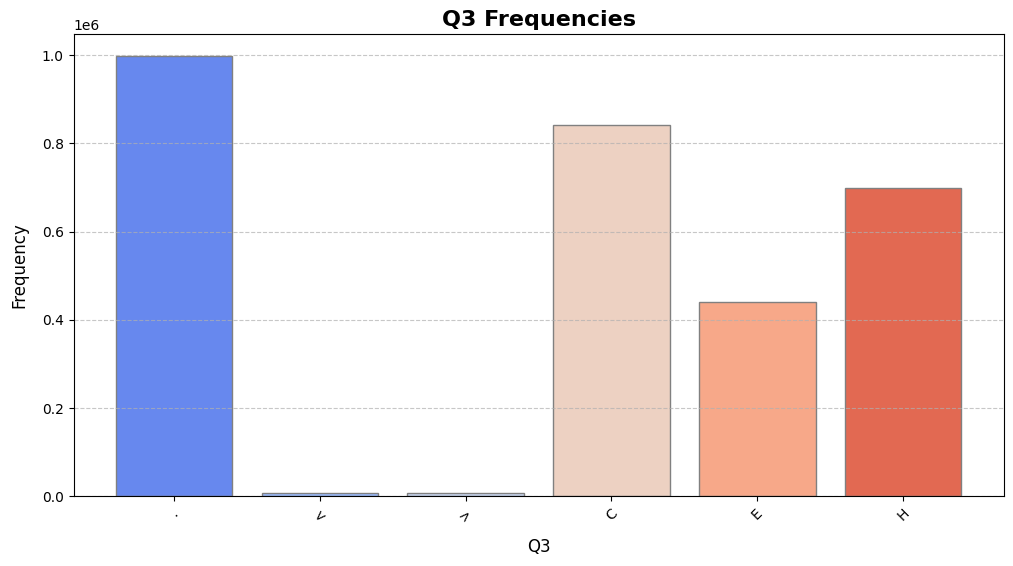

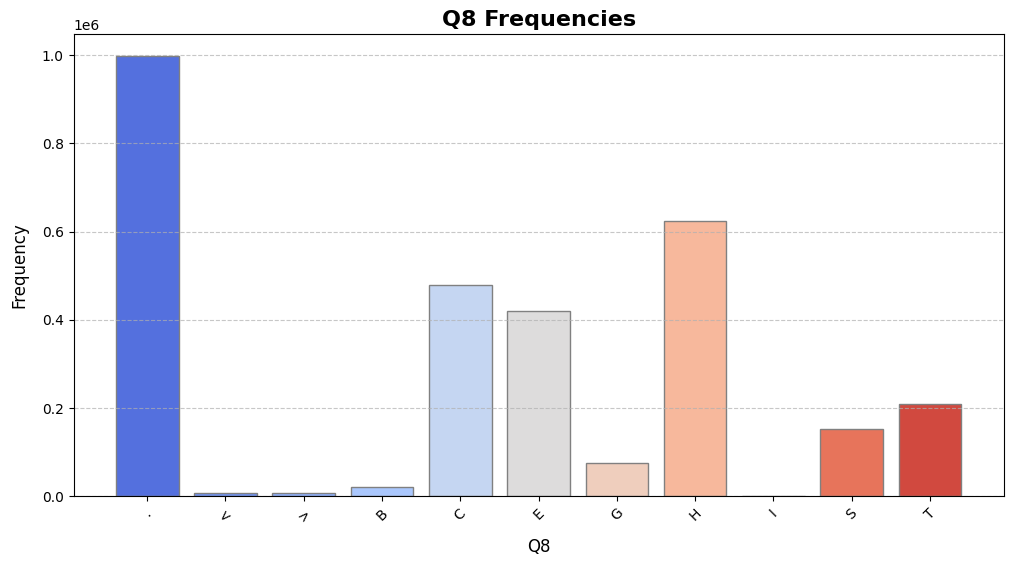

In [15]:
# Statistics for Class Frequency in Each Data Type (Sequence, Q3 & Q8)

colors_seq = sns.color_palette("coolwarm", len(seq_vocab))
seqs = np.array([seq_encoder(i) for i in seq_features])
seqs_freqs = np.unique(seqs , return_counts  = True)
seq_freqs = {i[0]:i[1] for i in zip(seqs_freqs[0] , seqs_freqs[1])}
plt.figure(figsize=(12, 6))
plt.bar([seq_itos[i] for i in list(seq_freqs.keys())] , seq_freqs.values() , color=colors_seq, edgecolor='grey')
plt.title('Sequence Frequencies', fontsize=16, weight='bold')
plt.xlabel('Sequence', fontsize=12, labelpad=10)
plt.ylabel('Frequency', fontsize=12, labelpad=10)
plt.xticks(rotation=45 , ticks = list(seq_freqs.keys()))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


colors_q3 = sns.color_palette("coolwarm", len(q3_vocab))
q3s = np.array([q3_encoder(i) for i in q3])
q3s_freqs = np.unique(q3s , return_counts  = True)
q3s_freqs = {i[0]:i[1] for i in zip(q3s_freqs[0] , q3s_freqs[1])}
plt.figure(figsize=(12, 6))
plt.bar([q3_itos[i] for i in list(q3s_freqs.keys())] , q3s_freqs.values() , color=colors_q3, edgecolor='grey')
plt.title('Q3 Frequencies', fontsize=16, weight='bold')
plt.xlabel('Q3', fontsize=12, labelpad=10)
plt.ylabel('Frequency', fontsize=12, labelpad=10)
plt.xticks(rotation=45 , ticks = list(q3s_freqs.keys()))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


colors_q8 = sns.color_palette("coolwarm", len(q8_vocab))
q8s = np.array([q8_encoder(i) for i in q8])
q8s_freqs = np.unique(q8s , return_counts  = True)
q8s_freqs = {i[0]:i[1] for i in zip(q8s_freqs[0] , q8s_freqs[1])}
plt.figure(figsize=(12, 6))
plt.bar([q8_itos[i] for i in list(q8s_freqs.keys())] , q8s_freqs.values() , color=colors_q8, edgecolor='grey')
plt.title('Q8 Frequencies', fontsize=16, weight='bold')
plt.xlabel('Q8', fontsize=12, labelpad=10)
plt.ylabel('Frequency', fontsize=12, labelpad=10)
plt.xticks(rotation=45 , ticks = list(q8s_freqs.keys()))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Conclusion: Sequences and Q3 do not present much imbalance between classes. Q8 is highly unbalanced, with I
# being almost not-present

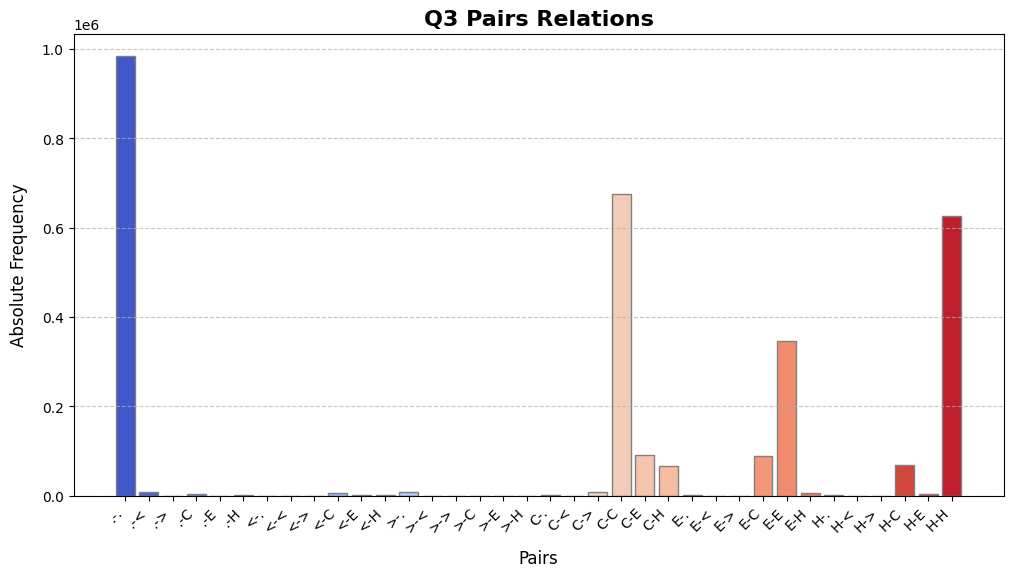

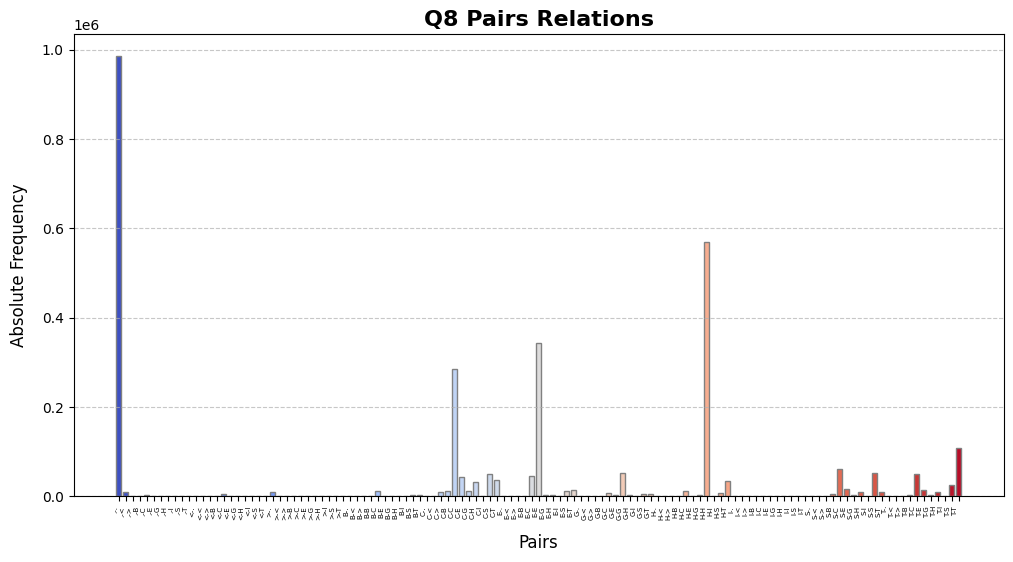

In [16]:
# Statistics on Bigram Frequencies

q3_pairs = {f"{i1}-{i2}":0 for i1 in list(q3_vocab) for i2 in list(q3_vocab)}
colors_q3_pairs = sns.color_palette("coolwarm", len(q3_pairs))
q3_all = "".join(q3)
for i in zip(q3_all , q3_all[1:]):
  q3_pairs[f"{i[0]}-{i[1]}"] +=1
plt.figure(figsize=(12, 6))
bars = plt.bar(q3_pairs.keys(), q3_pairs.values(), color=colors_q3_pairs, edgecolor='grey')
plt.title("Q3 Pairs Relations", fontsize=16, weight='bold')
plt.xlabel("Pairs", fontsize=12, labelpad=10)
plt.ylabel("Absolute Frequency", fontsize=12, labelpad=10)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


q8_pairs = {f"{i1}-{i2}":0 for i1 in list(q8_vocab) for i2 in list(q8_vocab)}
colors_q8_pairs = sns.color_palette("coolwarm", len(q8_pairs))
q8_all = "".join(q8)
for i in zip(q8_all , q8_all[1:]):
  q8_pairs[f"{i[0]}-{i[1]}"] +=1
plt.figure(figsize=(12, 6))
bars = plt.bar(q8_pairs.keys(), q8_pairs.values(), color=colors_q8_pairs, edgecolor='grey')
plt.title("Q8 Pairs Relations", fontsize=16, weight='bold')
plt.xlabel("Pairs", fontsize=12, labelpad=10)
plt.ylabel("Absolute Frequency", fontsize=12, labelpad=10)
plt.xticks(rotation=90, ha='right', fontsize=5)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Conclusion: Equipairs dominate the distribution. Highly unbalanced.

## Datasets & Dataloaders

In [17]:
# Torchification
X = torch.tensor(seqs , device=device)
Y_q3 = torch.tensor(q3s , device=device)
Y_q8 = torch.tensor(q8s , device=device)
data_dict = {'X':X , 'Y_q3':Y_q3, 'Y_q8':Y_q8}
torch.save(data_dict , 'notoken_data_dictionary')

print(f'X shape: {X.shape} | Y_q3 shape: {Y_q3.shape} | Y_q8 shape: {Y_q8.shape}')

X shape: torch.Size([12283, 244]) | Y_q3 shape: torch.Size([12283, 244]) | Y_q8 shape: torch.Size([12283, 244])


In [18]:
# Custom Dataset & Dataloader

class CustomDataset(Dataset):
    """This is the class for creating a custom DataSet given two tensors"""
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.y)
    def __getitem__(self,idx):
        return self.X[idx], self.y[idx]

def intialise_loaders(X_train , y_train , X_val , y_val , batch_size):
    """This function creates two dataloader given two numpy arrays"""
    train_dataset = CustomDataset(X = X_train , y = y_train)
    val_dataset = CustomDataset(X = X_val , y = y_val)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    return train_dataloader, val_dataloader

# Models

## LSTM

In [19]:
# Hyperparameters
batch_size = 256
context_size = max_len+2
max_iters = 15 # epochs
eval_interval = 1 # Estimate loss each x
lr = 3e-3
n_emb = int(32) # embedding dimension
vocab_size = len(seq_vocab)
q3_vocab_size = len(q3_vocab)
q8_vocab_size = len(q8_vocab)
n_layers = 8
hidden = 32
ker = 1
dropout = 0.4
patience = 3
md = 0.05 # min delta
fact = 0.1 # reduction on plateau
b1 = 0.9
b2 = 0.999

In [20]:
# LSTM Model

class ProteinLSTM(nn.Module):
    def __init__(self , vs , n_emb , n_layers , hidden , dropout , ker , vocab_size):
        super().__init__()
        self.enc_token_embeddings_table = nn.Embedding(vocab_size , n_emb , device=device)
        self.lstm = nn.LSTM(input_size=n_emb , num_layers = n_layers , hidden_size = hidden ,
                            batch_first = True, dropout=dropout)
        self.ln_1 = nn.LayerNorm(hidden)
        self.conv = nn.Conv1d(in_channels = hidden, out_channels = int(hidden/2), kernel_size = ker, padding = 'same')
        self.ln_2 = nn.LayerNorm(int(hidden/2))
        self.lk_rl = nn.LeakyReLU()
        self.lm_head = nn.Linear(int(hidden/2) , vs , device=device)

    def forward(self , x):
        x = self.enc_token_embeddings_table(x)
        x , _ = self.lstm(x)
        x = self.ln_1(x)
        x = self.conv(x.permute(0,2,1)).permute(0,2,1)
        x = self.lk_rl(self.ln_2(x))
        logits = self.lm_head(x)
        return logits

    def inference(self , x , enc):
      # This method allows for the input of a sequence of aminoacids, cropps it or pads it, encodes it and predicts
         # the structure of it

        # Number of structure tokens to predict (Structure Len == Sequence Length)
        iters = len(x)

        # Adjusting length
        if len(x) < context_size-2:
          # Padding
            x = ['<' + x + '>' + '.'*(context_size-len(x)-2)] # Adding SOS & EOS & Padding
            batches = 1
            idx = torch.full((batches, context_size), enc('.')[0], dtype=torch.int , device=device) # Prediction (initially empty)
            idx[0,0] = enc('<')[0] # Start of the sequence
            idx[-1,-1] = enc('<')[0] # End of Sequence

        elif len(x) > context_size-2:
          # Cropping
            x_1 = [x[i-context_size+1:i] for i in range(context_size-1 , len(x) , context_size)]
            x_2 = x[context_size * (int(len(x)/context_size)) : len(x)]
            x_2 = [x_2 + '>' + '.'*(context_size-len(x_2)-1)][0]
            x = [x_1[i] + '.' if i != 0 else '<' + x_1[i] for i in range(len(x_1))]
            x.append(x_2)
            batches = len(x)
            idx = torch.full((batches, context_size), enc('.')[0], dtype=torch.int , device=device)
            idx[:,0] = enc('<')[0]

        else:
          # Exact Legnth
            x = ['<' + x + '>']
            batches = 1
            idx = torch.full((batches, context_size), enc('.')[0], dtype=torch.int , device=device)
            idx[0,0] = enc('<')[0] # Start of the sequence
            idx[-1,-1] = enc('<')[0] # End of Sequence

        # Encoding & Torchification
        x = torch.tensor([enc(i) for i in x] , device=device)

        # Sampling from the distribution
        probs = F.softmax(self(x) , dim=-1)
        B, T, C = probs.shape
        probs_flat = probs.view(-1, C)
        idx = torch.multinomial(probs_flat , num_samples=1, replacement=True)
        return idx

In [21]:
# Early Stopper Class (Extracted from Tutorial)
class EarlyStopper:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False



# Training Class
class Training:
    def __init__(self , data , model , hyperparams , vocab_dict , loss_func , verbose=False , valid = True):
        # Data Loaders
        if valid:
          self.train_loader , self.val_loader = intialise_loaders(data['x_train'] , data['y_train'] ,
                                                                  data['x_val'] , data['y_val'] , hyperparams['batch_size'])
        else:
          self.train_loader , self.val_loader = intialise_loaders(data['x_train'] , data['y_train'] ,
                                                                  data['x_train'] , data['y_train'] , hyperparams['batch_size'])
          self.val_loader = 0

        self.model = model
        self.optimizer = torch.optim.AdamW(model.parameters() , lr = hyperparams['lr'] , betas = (hyperparams['b1'] , hyperparams['b2']))
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', factor=hyperparams['factor'], patience=hyperparams['patience'])
        self.hist_loss = {'train':[] , 'val':[]} # Historical Losses
        self.hist_acc = {'train':[] , 'val':[]} # Historical Accuracies
        self.hist_pres = {'train':[] , 'val':[]} # Historical Presicion
        self.hist_f1 = {'train':[] , 'val':[]} # Historical F1
        self.times = [] # Historical Epoch times
        self.hyper = hyperparams # Hyperparameter dictionary
        self.vocab = vocab_dict # stoi
        self.loss_func = loss_func
        self.early = EarlyStopper(patience = self.hyper['patience'] , min_delta = self.hyper['min_delta'])
        self.verbose = verbose

    def __call__(self, *args, **kwargs):
      # Training loop
      for i in range(self.hyper['epochs']):
            t = time.time()
            lossi = 0
            acci = 0
            all_preds = []
            all_targets = []
            for batch , (X_i,y_i) in enumerate(self.train_loader):
              # Foward Pass
                logits = self.model(X_i)
                probs = F.softmax(logits , dim=-1)
                B,T,C = logits.shape

                # Metrics & Loss
                loss = self.loss_func(logits.view(B*T,C) , y_i.view(B*T))
                acc = (torch.argmax(probs , dim=-1) == y_i).float().mean()
                all_preds.extend(torch.argmax(probs , dim=-1).view(-1).cpu().numpy())
                all_targets.extend(y_i.view(-1).cpu().numpy())
                lossi += loss.item()
                acci += acc.item()

                # Backward Pass & Update
                self.optimizer.zero_grad(set_to_none=True)
                loss.backward()
                self.optimizer.step()

            # Update of historical data
            self.hist_loss['train'].append(lossi/len(self.train_loader))
            self.hist_acc['train'].append(acci/len(self.train_loader))
            self.hist_pres['train'].append(precision_score(all_targets , all_preds , average='weighted' , zero_division=1))
            self.hist_f1['train'].append(f1_score(all_targets , all_preds , average='weighted' , zero_division=1))
            if self.verbose:
                print(f'Epoch: {i+1}/{self.hyper["epochs"]} | Training Loss: {self.hist_loss["train"][-1]:.5f} | Training Accuracy: {self.hist_acc["train"][-1]:.5f} |'
                      f'Training Precision: {self.hist_pres["train"][-1]:.5f} | Training F1-Score: {self.hist_f1["train"][-1]:.5f}')

            if i % self.hyper['eval_int'] == 0 and isinstance(self.val_loader , int) == False:
              # Validation Evaluation
                lossi = 0
                acci = 0
                all_preds = []
                all_targets = []
                for batch , (X_i,y_i) in enumerate(self.val_loader):
                  # Foward Pass
                    logits = self.model(X_i)
                    probs = F.softmax(logits , dim=-1)
                    B,T,C = logits.shape

                  # Metrics & Loss
                    loss = self.loss_func(probs.view(B*T,C),y_i.view(B*T))
                    lossi += loss.item()
                    acc = (torch.argmax(probs , dim=-1) == y_i).float().mean()
                    acci += acc.item()
                    all_preds.extend(torch.argmax(probs , dim=-1).view(-1).cpu().numpy())
                    all_targets.extend(y_i.view(-1).cpu().numpy())

                # Update Historical Data
                self.hist_acc['val'].append(acci/len(self.val_loader))
                self.hist_loss['val'].append(lossi/len(self.val_loader))
                self.hist_pres['val'].append(precision_score(all_targets , all_preds , average='weighted' , zero_division=1))
                self.hist_f1['val'].append(f1_score(all_targets , all_preds , average='weighted' , zero_division=1))
                # Early Stop Mechanism
                stop = self.early.early_stop(1/self.hist_f1['val'][-1])
                if stop:
                  if self.verbose:
                    print(f'Patience surpassed --> Stopping')
                  break
                self.scheduler.step(1/self.hist_f1['val'][-1])
                if self.verbose:
                    print(f'Epoch: {i+1}/{self.hyper["epochs"]} | Validation Loss: {self.hist_loss["val"][-1]:.5f} | '
                          f'Validation Accuracy: {self.hist_acc["val"][-1]:.5f} | Learning Rate: {self.optimizer.param_groups[0]["lr"]} | '
                          f'Validation Precision: {self.hist_pres["val"][-1]:.5f} | Validation F1-Score: {self.hist_f1["val"][-1]:.5f}')
            self.times.append(time.time()-t)

## Evaluation functions

In [22]:
def plot_learning_curves(tr):
    plt.figure(figsize=(8, 5))
    plt.plot(tr.hist_loss['train'], label='Training Loss')
    plt.plot(tr.hist_loss['val'], label='Validation Loss')
    plt.title('Learning Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.plot(tr.hist_acc['train'], label='Training Accuracy')
    plt.plot(tr.hist_acc['val'], label='Validation Accuracy')
    plt.title('Learning Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

In [23]:
def plot_confusion_matrix(model, tr, itos, stoi, title='Confusion Matrix'):
    model.eval()

    # Initialize lists to store all predictions and labels
    all_preds = []
    all_labels = []

    # Get the padding index to exclude it from the confusion matrix
    pad_idx = stoi['.']

    with torch.no_grad():
        for batch, (X_i, y_i) in enumerate(tr.val_loader):
            logits = model(X_i)
            preds = torch.argmax(logits, dim=-1)

            # Flatten predictions and labels using reshape instead of view
            preds_flat = preds.reshape(-1)
            y_i_flat = y_i.reshape(-1)

            # Create a mask to exclude padding tokens in both labels and predictions
            mask = (y_i_flat != pad_idx) & (preds_flat != pad_idx)

            # Apply the mask and move tensors to CPU
            preds_flat = preds_flat[mask].cpu()
            y_i_flat = y_i_flat[mask].cpu()

            # Append to the lists
            all_preds.append(preds_flat)
            all_labels.append(y_i_flat)

    # Concatenate all predictions and labels
    y_pred = torch.cat(all_preds)
    y_true = torch.cat(all_labels)

    # Convert to numpy arrays if they aren't already
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Dynamically retrieve the padding index, default to -1 if `.` is not found
    padding_index = stoi.get('.', -1)
    ignore_index = -100

    # Exclude padding and ignore positions (where y_true == ignore_index or padding index)
    mask = (y_true != ignore_index) & (y_true != padding_index)
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]

    # Verify that y_true_filtered and y_pred_filtered contain valid class labels
    valid_labels = sorted(set(y_true_filtered) | set(y_pred_filtered))
    print(f"Valid labels after filtering: {valid_labels}")

    # Generate confusion matrix with the filtered data
    cm = confusion_matrix(y_true_filtered, y_pred_filtered, labels=valid_labels)
    plt.gcf().set_size_inches(12, 10)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[itos[label] for label in valid_labels],
                yticklabels=[itos[label] for label in valid_labels])
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')

    # Save the confusion matrix plot before showing it
    #confusion_matrix_path = os.path.join(full_folder_path, 'confusion_matrix.png')
    #plt.savefig(confusion_matrix_path)
    #print(f"Confusion matrix plot saved at: {confusion_matrix_path}")

    # Display the plot
    plt.show()

## Initial Predictions

#### Q3

In [24]:
# Splitting Data
# Validation Set
vix = torch.randperm(X.shape[0])[:int(X.shape[0]*.15)] # Validation Indices
x_val = X[vix,:]
y_val = Y_q3[vix,:]

# Training Set
ix = torch.tensor(list(set(range(X.shape[0])) - set([i.item() for i in vix]))) # Training Indices
x_tr = X[ix]
y_tr = Y_q3[ix]

# Preparing Inputs
data = {'x_train':x_tr , 'y_train':y_tr , 'x_val':x_val , 'y_val':y_val}
hy =  {'batch_size':batch_size , 'epochs':15 , 'lr':lr , 'eval_int':eval_interval , 'patience':patience , 'factor':fact , 'min_delta':md , 'b1':b1 , 'b2':b2}
pr = ProteinLSTM(q3_vocab_size , n_emb , n_layers , hidden , dropout , ker , vocab_size)
pr.to(device)
loss_func = nn.CrossEntropyLoss(ignore_index=q3_stoi['.'])
print(f"Model's trainable parameters: {sum([i.numel() for i in pr.parameters()])}")

# Training Loop
tr = Training(data , pr , hy , q3_stoi , loss_func , verbose=True)
tr()

Model's trainable parameters: 69078
Epoch: 1/15 | Training Loss: 1.36703 | Training Accuracy: 0.21810 |Training Precision: 0.26045 | Training F1-Score: 0.17315
Epoch: 1/15 | Validation Loss: 1.64894 | Validation Accuracy: 0.28449 | Learning Rate: 0.003 | Validation Precision: 0.79644 | Validation F1-Score: 0.12603
Epoch: 2/15 | Training Loss: 1.14339 | Training Accuracy: 0.28104 |Training Precision: 0.65705 | Training F1-Score: 0.12924
Epoch: 2/15 | Validation Loss: 1.62811 | Validation Accuracy: 0.28662 | Learning Rate: 0.003 | Validation Precision: 0.63426 | Validation F1-Score: 0.19971
Epoch: 3/15 | Training Loss: 1.11425 | Training Accuracy: 0.28103 |Training Precision: 0.65130 | Training F1-Score: 0.14012
Epoch: 3/15 | Validation Loss: 1.62370 | Validation Accuracy: 0.28403 | Learning Rate: 0.003 | Validation Precision: 0.63105 | Validation F1-Score: 0.12892
Epoch: 4/15 | Training Loss: 1.09568 | Training Accuracy: 0.28107 |Training Precision: 0.63021 | Training F1-Score: 0.12386


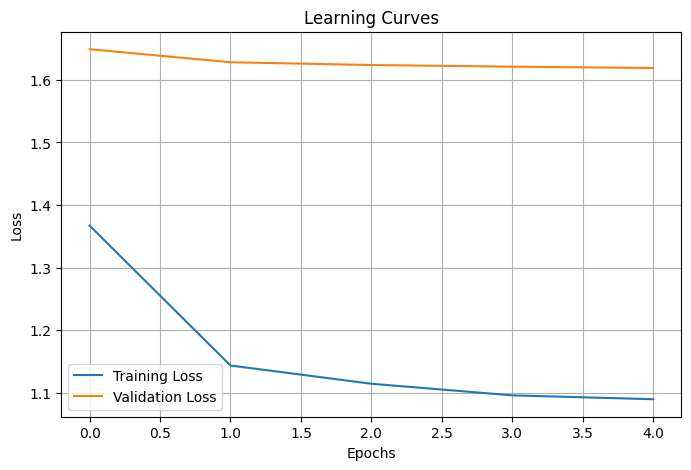

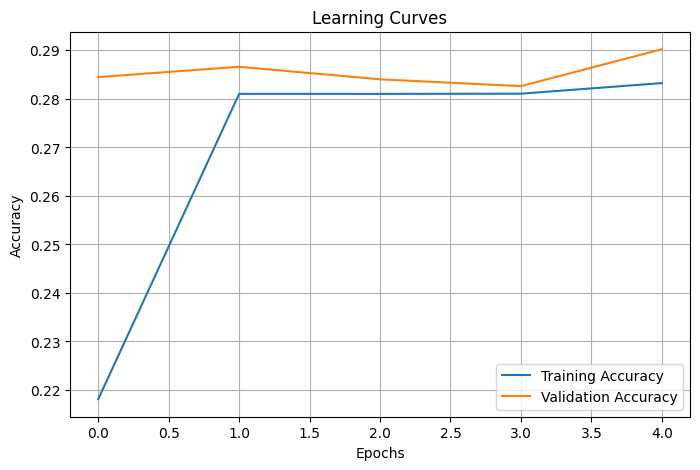

Valid labels after filtering: [1, 2, 3, 4, 5]


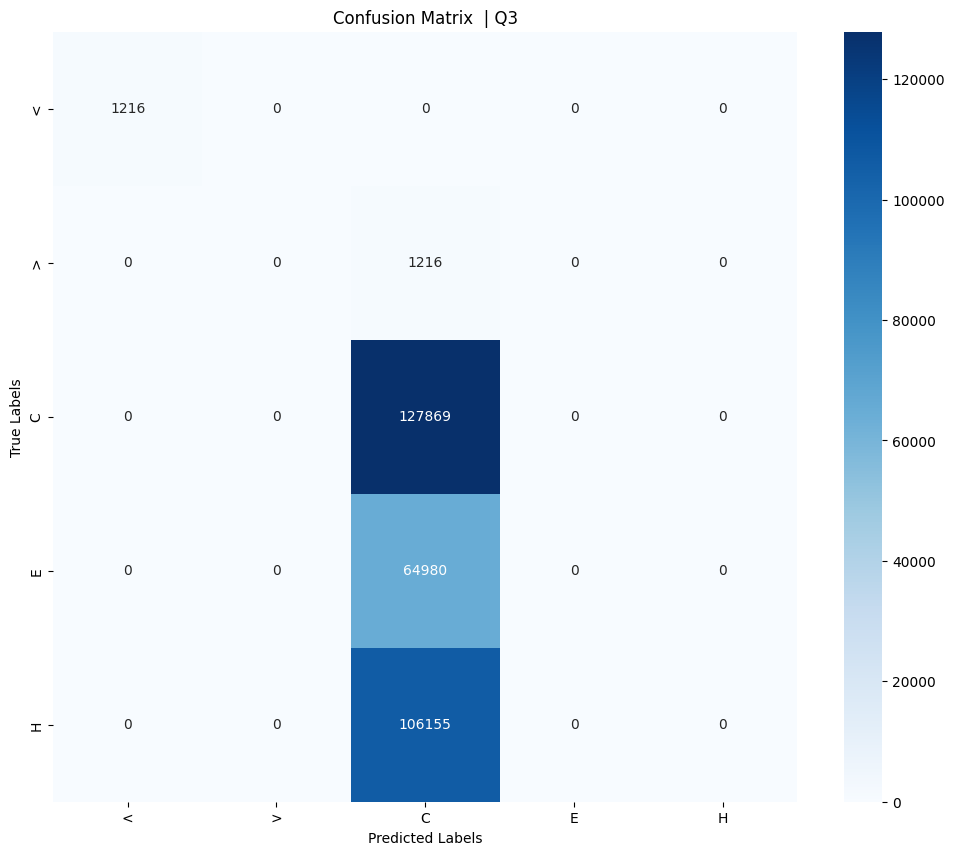

In [25]:
# Results
plot_learning_curves(tr)
plot_confusion_matrix(pr, tr, q3_itos, q3_stoi, title='Confusion Matrix  | Q3')

# Conclusion: Loss curves behave nicely. They appear to be approaching convergence, but
# still not converging completely around .9
# This is a good loss for a problem with 3 classes and, beyond this, the model does not appear
# to present signs of overfitting.

#### Q8

In [ ]:
# Splitting Data
# Validation Set
vix = torch.randperm(X.shape[0])[:int(X.shape[0]*.15)] # Validatin Indices
x_val = X[vix,:]
y_val = Y_q8[vix,:]

# Training Set
ix = torch.tensor(list(set(range(X.shape[0])) - set([i.item() for i in vix]))) # Training Indices
x_tr = X[ix]
y_tr = Y_q8[ix]

# Preparing Inputs
data = {'x_train':x_tr , 'y_train':y_tr , 'x_val':x_val , 'y_val':y_val}
hy =  {'batch_size':batch_size , 'epochs':15 , 'lr':lr , 'eval_int':eval_interval , 'patience':patience , 'factor':fact , 'min_delta':md , 'b1':b1 , 'b2':b2}
pr = ProteinLSTM(q8_vocab_size , n_emb , n_layers , hidden , dropout , ker , vocab_size)
pr.to(device)
loss_func = nn.CrossEntropyLoss(ignore_index=q3_stoi['.'])
print(f"Model's trainable parameters: {sum([i.numel() for i in pr.parameters()])}")

# Training Loop
tr = Training(data , pr , hy , q8_stoi , loss_func , verbose=True)
tr()

Model's trainable parameters: 69163
Epoch: 1/15 | Training Loss: 1.85075 | Training Accuracy: 0.20715 |Training Precision: 0.36834 | Training F1-Score: 0.09338
Epoch: 1/15 | Validation Loss: 1.71597 | Validation Accuracy: 0.22552 | Learning Rate: 0.003 | Validation Precision: 0.70886 | Validation F1-Score: 0.11261
Epoch: 2/15 | Training Loss: 1.68830 | Training Accuracy: 0.22459 |Training Precision: 0.70489 | Training F1-Score: 0.11031
Epoch: 2/15 | Validation Loss: 1.66523 | Validation Accuracy: 0.22612 | Learning Rate: 0.003 | Validation Precision: 0.70738 | Validation F1-Score: 0.11094
Epoch: 3/15 | Training Loss: 1.65327 | Training Accuracy: 0.22867 |Training Precision: 0.70906 | Training F1-Score: 0.11824
Epoch: 3/15 | Validation Loss: 1.62120 | Validation Accuracy: 0.24293 | Learning Rate: 0.003 | Validation Precision: 0.72463 | Validation F1-Score: 0.13474
Epoch: 4/15 | Training Loss: 1.59064 | Training Accuracy: 0.24843 |Training Precision: 0.64197 | Training F1-Score: 0.14452


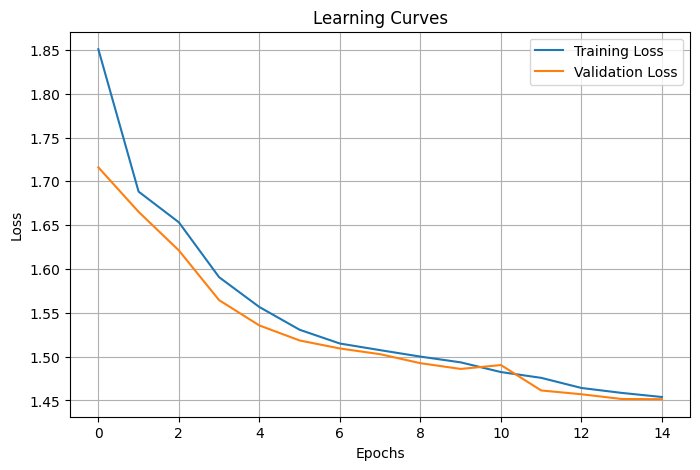

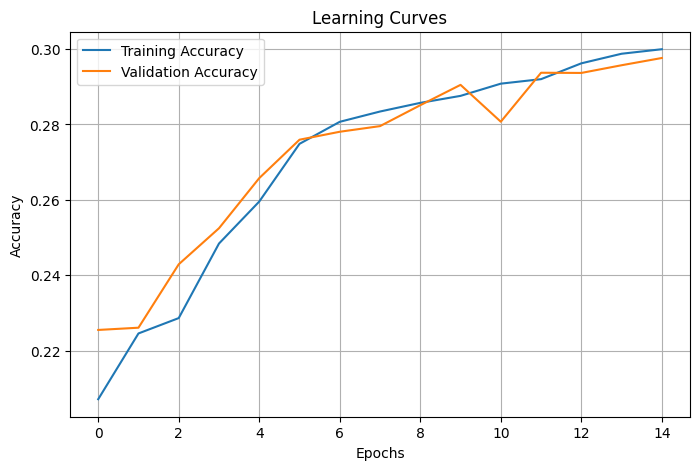

Valid labels after filtering: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


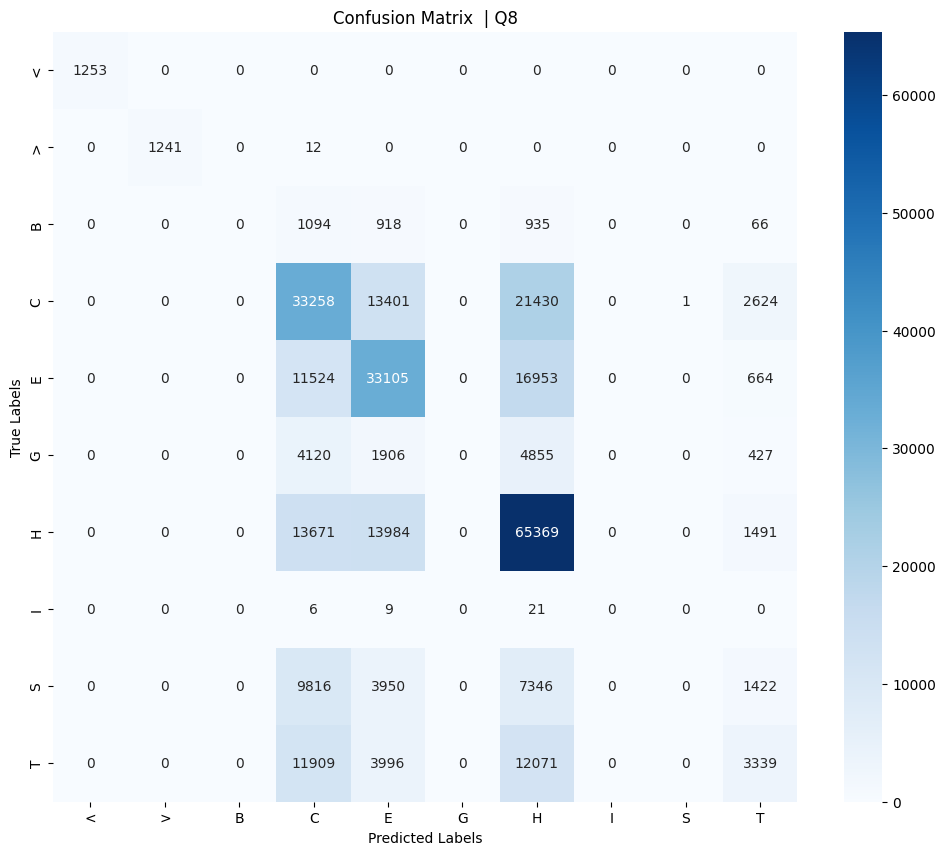

In [ ]:
# Results
plot_learning_curves(tr)
plot_confusion_matrix(pr, tr, q8_itos, q8_stoi, title='Confusion Matrix  | Q8')

# Conclusion: The loss curves appear to behave in good manner and they still did not
# converge. A loss of 1.45 was reach with no great overfitting, both of which are good
# signs.

## Hyperparameter Tunning w/ Bayesian Optmization

In [ ]:
# K-Fold CV Splitting

datasets = {'train':[] , 'val':[]} # Dictionary to host the splits
k = KFold(n_splits=3, shuffle=True, random_state=42)

# Loop to extract the splits
for tr,vl in k.split(np.array([i for i in range(X.shape[0])])):
    tr = torch.tensor(tr , dtype=torch.int , device=device)
    vl = torch.tensor(vl , dtype=torch.int , device=device)
    datasets['train'].append(tr)
    datasets['val'].append(vl)

In [ ]:
# Bayes Optimization Search Hyperparams

# Bounded region of parameter space
pbounds = {'lr' : (10e-5, 0.1) , 'batch_size' : (32,256) , 'n_emb' : (4,256) , 'hidden' : (16,64) ,
           'n_layers' : (2,16) , 'dropout' : (.1,.5) , 'patience' : (0,3) ,
           'factor' : (0.01,.5) , 'min_delta' : (0.01,0.1) , 'b1':(0.9,0.999) , 'b2':(0.95,0.9999)}

# Bayes Search Values
init_p = 10
n_iter = 5

#### Q3

In [ ]:
def bayes_opt_func(lr , batch_size , n_emb , n_layers , hidden , dropout , patience , factor , min_delta , b1 , b2):
  """This function has to be maximized by the Bayesian Optimization"""

  # Extracting hyperparams from inputs (Inputs might be continues, but some hyperparams must be ints)
  n_emb = int(n_emb)
  n_layers = int(n_layers)
  hidden = int(hidden)
  batch_size = int(batch_size)
  patience = int(patience)

  # Historical F1s (Function will maximize F1, not loss)
  f1s = []

  # Cross-Validation
  for i in range(len(datasets['train'])):
    model = ProteinLSTM(q3_vocab_size , n_emb , n_layers , hidden , dropout , ker=1 , vocab_size=vocab_size)
    model.to(device)
    data = {'x_train':X[datasets['train'][i],:] , 'y_train':Y_q3[datasets['train'][i],:] ,
            'x_val':X[datasets['val'][i],:] , 'y_val':Y_q3[datasets['val'][i],:]} # Changed 'y_val':X[...] to 'y_val':Y_q3[...] to ensure correct validation data
    hy = {'batch_size':batch_size , 'epochs':10 , 'lr':lr , 'eval_int':eval_interval , 'patience':patience ,
          'factor':factor , 'min_delta':min_delta, 'b1':b1 , 'b2':b2}
    loss_func = nn.CrossEntropyLoss(ignore_index=q3_stoi['.'])
    tr = Training(data , model , hy , q3_stoi , loss_func , verbose=False)
    tr()

    f1s.append(tr.hist_f1['val'][-1])

  # Returning mean F1 acros different splits
  return np.mean(f1s)

In [ ]:
# CV Search

optimizer = BayesianOptimization(
    f=bayes_opt_func,
    pbounds=pbounds,
    random_state=seed,
)

optimizer.maximize(
    init_points = init_p,
    n_iter = n_iter,
)

|   iter    |  target   |    b1     |    b2     | batch_... |  dropout  |  factor   |  hidden   |    lr     | min_delta |   n_emb   | n_layers  | patience  |
-------------------------------------------------------------------------------------------------------------------------------------------------------------
| 1         | 0.239     | 0.9764    | 0.951     | 173.9     | 0.3995    | 0.2543    | 26.79     | 0.01989   | 0.07845   | 46.62     | 3.237     | 2.056     |
| 2         | 0.1151    | 0.9944    | 0.9502    | 146.7     | 0.425     | 0.3101    | 50.64     | 0.02926   | 0.0926    | 184.1     | 9.596     | 0.4265    |
| 3         | 0.1258    | 0.937     | 0.9836    | 131.0     | 0.2736    | 0.3127    | 40.63     | 0.06507   | 0.06409   | 206.9     | 9.303     | 2.726     |
| 4         | 0.3093    | 0.9316    | 0.9545    | 99.36     | 0.1456    | 0.4161    | 18.25     | 0.06267   | 0.05928   | 210.5     | 4.785     | 2.571     |
| 5         | 0.2266    | 0.9348    | 0.9877    | 98

#### Q8

In [ ]:
def bayes_opt_func(lr , batch_size , n_emb , n_layers , hidden , dropout , patience , factor , min_delta , b1 , b2):
  """This function has to be maximized by the Bayesian Optimization"""

  # Extracting hyperparams from inputs (Inputs might be continues, but some hyperparams must be ints)
  n_emb = int(n_emb)
  n_layers = int(n_layers)
  hidden = int(hidden)
  batch_size = int(batch_size)
  patience = int(patience)

  # Historical F1s (Function will maximize F1, not loss)
  f1s = []

  # Cross-Validation
  for i in range(len(datasets['train'])):
    model = ProteinLSTM(q8_vocab_size , n_emb , n_layers , hidden , dropout , ker=1 , vocab_size=vocab_size)
    model.to(device)
    data = {'x_train':X[datasets['train'][i],:] , 'y_train':Y_q8[datasets['train'][i],:] ,
            'x_val':X[datasets['val'][i],:] , 'y_val':Y_q8[datasets['val'][i],:]} # Changed 'y_val':X[...] to 'y_val':Y_q3[...] to ensure correct validation data
    hy = {'batch_size':batch_size , 'epochs':15 , 'lr':lr , 'eval_int':eval_interval ,
          'patience':patience , 'factor':factor , 'min_delta':min_delta, 'b1':b1 , 'b2':b2}
    loss_func = nn.CrossEntropyLoss(ignore_index=q8_stoi['.'])
    tr = Training(data , model , hy , q8_stoi , loss_func , verbose=False)
    tr()

    f1s.append(tr.hist_f1['val'][-1])

  # Returning mean F1 acros different splits
  return np.mean(f1s)

In [ ]:
# CV Search

optimizer = BayesianOptimization(
    f=bayes_opt_func,
    pbounds=pbounds,
    random_state=seed,
)

optimizer.maximize(
    init_points = init_p,
    n_iter = n_iter,
)

|   iter    |  target   |    b1     |    b2     | batch_... |  dropout  |  factor   |  hidden   |    lr     | min_delta |   n_emb   | n_layers  | patience  |
-------------------------------------------------------------------------------------------------------------------------------------------------------------
| 1         | 0.1933    | 0.9764    | 0.951     | 173.9     | 0.3995    | 0.2543    | 26.79     | 0.01989   | 0.07845   | 46.62     | 3.237     | 2.056     |
| 2         | 0.09586   | 0.9944    | 0.9502    | 146.7     | 0.425     | 0.3101    | 50.64     | 0.02926   | 0.0926    | 184.1     | 9.596     | 0.4265    |
| 3         | 0.1099    | 0.937     | 0.9836    | 131.0     | 0.2736    | 0.3127    | 40.63     | 0.06507   | 0.06409   | 206.9     | 9.303     | 2.726     |
| 4         | 0.1964    | 0.9316    | 0.9545    | 99.36     | 0.1456    | 0.4161    | 18.25     | 0.06267   | 0.05928   | 210.5     | 4.785     | 2.571     |
| 5         | 0.203     | 0.9348    | 0.9877    | 98

## Model w/ Optimized Hyperparams

#### Q3

In [ ]:
# Preparing Inputs

data = {'x_train':X , 'y_train':Y_q3 , 'x_val':X , 'y_val':Y_q3}
hy = {'batch_size':128 , 'epochs':15 , 'lr':0.0315 , 'eval_int':eval_interval ,
      'patience':2 , 'factor':0.03 , 'min_delta':0.07 , 'b1':0.91 , 'b2':0.965}
pr = ProteinLSTM(q3_vocab_size , n_emb=128 , n_layers=2 , hidden=32 , dropout=0.4 , ker=1 , vocab_size=vocab_size)
pr.to(device)
loss_func = nn.CrossEntropyLoss(ignore_index=q3_stoi['.'])
print(f"Model's trainable parameters: {sum([i.numel() for i in pr.parameters()])}")

# Training Loop
tr = Training(data , pr , hy , q3_stoi , loss_func , verbose = True , valid = False)
tr()
# Saving Model
torch.save(pr.state_dict(), 'Q3_protein_lstm_notoken.pth')

Model's trainable parameters: 32982
Epoch: 1/15 | Training Loss: 1.00390 | Training Accuracy: 0.34973 |Training Precision: 0.46270 | Training F1-Score: 0.28929
Epoch: 2/15 | Training Loss: 0.92839 | Training Accuracy: 0.37176 |Training Precision: 0.65167 | Training F1-Score: 0.33273
Epoch: 3/15 | Training Loss: 0.91128 | Training Accuracy: 0.37918 |Training Precision: 0.66888 | Training F1-Score: 0.34853
Epoch: 4/15 | Training Loss: 0.89899 | Training Accuracy: 0.38433 |Training Precision: 0.66196 | Training F1-Score: 0.34535
Epoch: 5/15 | Training Loss: 0.89444 | Training Accuracy: 0.38593 |Training Precision: 0.67037 | Training F1-Score: 0.35256
Epoch: 6/15 | Training Loss: 0.88926 | Training Accuracy: 0.38803 |Training Precision: 0.67054 | Training F1-Score: 0.35345
Epoch: 7/15 | Training Loss: 0.88847 | Training Accuracy: 0.38884 |Training Precision: 0.67250 | Training F1-Score: 0.35443
Epoch: 8/15 | Training Loss: 0.88615 | Training Accuracy: 0.38996 |Training Precision: 0.68316 |

In [ ]:
# Testing
# Creating initial model
pr =  ProteinLSTM(q3_vocab_size , n_emb=128 , n_layers=2 , hidden=32 , dropout=0.4 , ker=1  , vocab_size=vocab_size)
pr.to(device)
# Loading weights
state_dict = torch.load('/content/Q3_protein_lstm_notoken.pth')
pr.load_state_dict(state_dict)
pr.eval()

print(q3_stoi,'\n\n')
count = 0
acc_total = 0
for i in range(df_test.shape[0]):
  count += 1
  # Predicting & Decoding Structure
  pred = q3_decoder(pr.inference(list(df_test['seq'])[i] , seq_encoder).cpu().numpy().flatten()[0:len(list(df_test['sst3'])[i])])
  pred = [item for i in pred for item in (i if isinstance(i, tuple) else [i])][0:len(list(df_test['sst3'])[i])]
  final_pred = ''.join(pred)
  ground_truth = list(df_test['sst3'])[i]
  acc = [1 if i[0] == i[1] else 0 for i in zip(final_pred[1:],ground_truth)]
  acc_perc = sum(acc)/len(acc)
  acc_total += acc_perc

  # Checking Results
  if i % 10 == 0:
    print(f'Predicted structure:\n' , final_pred)
    print(f'True structure:\n' , ground_truth)
    print(f'Accuracy: {acc_perc} \n\n')
print(f'Average Accuracy: {acc_total/count}')

# Conclusion: the model appears to be achieving good accuracies by reaching a middle
# point between diversity and the dominance of C. The overall loss is significantly better than
# chance, but still very far away from perfect.

<ipython-input-26-d953cb2314e2>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('/content/Q3_protein_lstm_notoken.pth')


{'.': 0, '<': 1, '>': 2, 'C': 3, 'E': 4, 'H': 5} 


Predicted structure:
 <CCCHCEHHEHHEEHHCCECHECEECHHCCCHCECEEHHCHEEEEECEHCECHHHHCCCCCEHCHCHEHCCHHCCECHCHCCECEHCCCCCHCHCCHHHHEHHHHHCCCHHHCHHHCCECCECCCCCCECHCHHCHHHCCCCHHCHCEHHCCHCCHEEEECHCHEHCHCCCHHHHHHHCHHHHCCCECHEECECHCCCCCCHEHCCECCHHCEHCECEHCCHHHCHHCECHHCEEHEEEHCCCE<CHHHEHCCCHHHHHHCHHCHCCECHHHCCEHEHCHCHHHCHEHCCHHHEH
True structure:
 CCCCCCHHHHHHHHHHCCCCEEEEEECCHHHHHHHHHHCCCCEEECCHHHHHCCCCCCCCCCCCHHHHHHHHHHHHCCCCCEEEECCCCCCCHHHHHHHHHHHHHCCCCEEEEECECCCCCCCCCCCCCCCECCHHHHHHHHHHHHHHCCCCCCEEEEEECCCCCCCCHHHHHHHHHHHHHCCCCEEEECCCCCCCHHHHHHHHHHCCCCCEEECCCCCCCCCHHHHHHHCCCEEEECCHHHHHHHHHHHHHHHHHHHHCCCCCCHHHCCCHHHHHHCCCCCCCCCCCCCCCCCC
Accuracy: 0.4931972789115646 


Predicted structure:
 <CCCCEHCEHHCCCCCCHCHHCCHCCCHCEECHHHCCHCHEEEEHCCCHCHHHHHEHHCE
True structure:
 CCCCCCCCCCEEEECCCCCCCCCCCCEEEEEEEECCCCEEEEEEEECCCCCCCCCCCCCC
Accuracy: 0.423728813559322 


Predicted structure:
 <CCCCHCCHHHHCHCCCHHEHHEHCCHHCCHEHCHHHHCCHEHECHHECCHHCCCCCCEEEEECCCCCEHH

#### Q8

In [ ]:
# Preparing Inputs

data = {'x_train':X , 'y_train':Y_q8 , 'x_val':X , 'y_val':Y_q8}
hy = {'batch_size':128 , 'epochs':15 , 'lr':0.0315 , 'eval_int':eval_interval ,
      'patience':2 , 'factor':0.03 , 'min_delta':0.07 , 'b1':0.901 , 'b2':0.965}
pr = ProteinLSTM(q8_vocab_size , n_emb=90 , n_layers=2 , hidden=32 , dropout=0.4 , ker=1 , vocab_size=vocab_size)
pr.to(device)
loss_func = nn.CrossEntropyLoss(ignore_index=q8_stoi['.'])
print(f"Model's trainable parameters: {sum([i.numel() for i in pr.parameters()])}")

# Training Loop
tr = Training(data , pr , hy , q8_stoi , loss_func , verbose=True , valid = False)
tr()
# Saving Model
torch.save(pr.state_dict(), 'Q8_protein_lstm_notoken.pth')

Model's trainable parameters: 27291
Epoch: 1/15 | Training Loss: 1.60344 | Training Accuracy: 0.25159 |Training Precision: 0.20291 | Training F1-Score: 0.17817
Epoch: 2/15 | Training Loss: 1.46990 | Training Accuracy: 0.29152 |Training Precision: 0.58107 | Training F1-Score: 0.22776
Epoch: 3/15 | Training Loss: 1.45049 | Training Accuracy: 0.29802 |Training Precision: 0.59336 | Training F1-Score: 0.23429
Epoch: 4/15 | Training Loss: 1.44068 | Training Accuracy: 0.30153 |Training Precision: 0.59478 | Training F1-Score: 0.23670
Epoch: 5/15 | Training Loss: 1.43318 | Training Accuracy: 0.30482 |Training Precision: 0.59182 | Training F1-Score: 0.23954
Epoch: 6/15 | Training Loss: 1.42585 | Training Accuracy: 0.30787 |Training Precision: 0.59652 | Training F1-Score: 0.24229
Epoch: 7/15 | Training Loss: 1.42318 | Training Accuracy: 0.30890 |Training Precision: 0.59864 | Training F1-Score: 0.24344
Epoch: 8/15 | Training Loss: 1.41754 | Training Accuracy: 0.31117 |Training Precision: 0.60199 |

In [ ]:
# Testing
# Creating initial model
pr = ProteinLSTM(q8_vocab_size , n_emb=90 , n_layers=2 , hidden=32 , dropout=0.4 , ker=1 , vocab_size=vocab_size)
pr.to(device)
# Loading weights
state_dict = torch.load('/content/Q8_protein_lstm_notoken.pth')
pr.load_state_dict(state_dict)
pr.eval()

print(q8_stoi,'\n\n')
count = 0
acc_total = 0
for i in range(df_test.shape[0]):
  count += 1
  # Predicting & Decoding Structure
  pred = q8_decoder(pr.inference(list(df_test['seq'])[i] , seq_encoder).cpu().numpy().flatten()[0:len(list(df_test['sst3'])[i])])
  pred = [item for i in pred for item in (i if isinstance(i, tuple) else [i])][0:len(list(df_test['sst8'])[i])]
  final_pred = ''.join(pred)
  ground_truth = list(df_test['sst8'])[i]
  acc = [1 if i[0] == i[1] else 0 for i in zip(final_pred[1:],ground_truth)]
  acc_perc = sum(acc)/len(acc)
  acc_total += acc_perc

  # Checking Results
  if i % 10 == 0:
    print(f'Predicted structure:\n' , final_pred)
    print(f'True structure:\n' , ground_truth)
    print(f'Accuracy: {acc_perc} \n\n')
print(f'Average Accuracy: {acc_total/count}')

# The model appears to be failing in the prediction of the tokens intrinsic to the Q8
# structure's representation, like S and T. This might be because of their nature
# as under-represented classes, so the model has not enough observations of them to
# actually understand their representations. Still, the accuracy is significantly
# better than chance.

<ipython-input-25-4b5183307f78>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('/content/Q8_protein_lstm_notoken.pth')


{'.': 0, '<': 1, '>': 2, 'B': 3, 'C': 4, 'E': 5, 'G': 6, 'H': 7, 'I': 8, 'S': 9, 'T': 10} 


Predicted structure:
 <CCCCBCECHHHSEGTHTHGHCETHGHHHSSECHHEHTTSCHSECECSECHCCHHTEEEBCGECCHHHEHHHHEHHHHSHCCHEECESCTHCEEECECHHHHHHHTSSECCCHEEBSSSTTCSHGHTGHHHCBHHHHHTHHHHEHCHHHTTTCHTSHEEEHHEEHHHSSCCEHHHHCHHHHHHCBHCEEEHCTTHGTHHHHHETHHHHTHTCEEEEGCHESHESSSCHGEHSECSEEESCCCHT<ESHHCCCHCHCHGHCCHTHHHGTHCCHHHHHHHHCCSTEHHESCCSETHS
True structure:
 CCCCCCHHHHHHHHHHSSSCEEEEEECSHHHHHHHHHHTCSCEEECCHHHHHTCCCCCCCCCCCHHHHHHHHHHHHTCSSCEEEECCSSCSSHHHHHHHHHHHHHTTCCEEEEECBCCCCCCCCCCCTTCCBCCHHHHHHHHHHHHHHCSSTTCEEEEEECTTTTTCCHHHHHHHHHHHHHTTCSEEEECCCSSSSHHHHHHHHHHTTCSCEEECCSTTTTSCHHHHHHHTCCEEEECSHHHHHHHHHHHHHHHHHHHHSSSTTTGGGSCCHHHHHHCCCCCCCCCCCCCCCCCC
Accuracy: 0.38095238095238093 


Predicted structure:
 <CCCCCHGCHHTHHEECTTCTBCHGTHEHECHHTECSHHHEESECCESEHGHHHEETHSE
True structure:
 CCCCCCCCCCEEEECCTTSTTCCTTCEEEEEEEECSSCEEEEEEEECCCCCCCCCCCCCC
Accuracy: 0.3728813559322034 


Predicted structure:
 <CCCCEEHCCHHSSHHHHHHHHTHTHHC